In this notebook, I'll be implementing a precision-recall curve for a binary classifier which will predict whether breast cancer is benign or malignant given several features about the size, shape, mass etc. of each tumors. 

The precision-recall curve is an alternative to the receiver operating characteristic curve (ROC), which plots the true positive and false positive rates across different decision thresholds applied to a classifier.

The precision recall curve does the same, but instead uses **precision** and **recall**, where precision is the proportion of positive predictions which are correct, and recall is the proportion of positive samples which are correctly classified:

$$
\text{Precision} = \frac{TP}{TP + FP} 
$$

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

By sliding the *decision threshold*, that is, the predicted probability value above which we assign a sample to the positive class and below which we assign to the negative class, across (0, 1) exclusive and measuring both precision and recall at each point, we can create a plot that comprehensively summarizes the performance of our probabilistic classifier. 

In [69]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

In [4]:
# load data
data_path = '../data/breast_cancer_wisconsin_diagnosis.csv'

data = pl.read_csv(data_path)

data.head()

id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
842302,"""M""",17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,null
842517,"""M""",20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902,null
84300903,"""M""",19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,null
84348301,"""M""",11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,null
84358402,"""M""",20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678,null


In [59]:
DIAGNOSIS_TO_INT_MAPPING = {'B': 0, 'M': 1}

INT_TO_DIAGNOSIS_MAPPING = {v: k for k, v in DIAGNOSIS_TO_INT_MAPPING.items()}

DIAGNOSIS_TO_INT_MAPPING, INT_TO_DIAGNOSIS_MAPPING

({'B': 0, 'M': 1}, {0: 'B', 1: 'M'})

In [89]:
# process data into feature matrix (X) and target vector (y)
X = data.select(pl.exclude(['id', 'diagnosis', '']))
y = data['diagnosis'].replace_strict(old=DIAGNOSIS_TO_INT_MAPPING, return_dtype=pl.Int8).to_numpy()

In [108]:
# cross-validate and return predicted probabilities
y_proba = cross_val_predict(LogisticRegression(max_iter=5000), X=X, y=y, cv=10, method='predict_proba')

In [136]:
# implementing these from scratch even though I could just use scikit-learn's functions
def _validate_binary_target(x: np.ndarray) -> None:
    if not np.all(np.isin(x, [0, 1])):
        raise ValueError('target must be binary; all values should be either 0 or 1')


def compute_precision(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Compute precision, or the proportion of samples which are predicted to be positive that are actually positive

    Args:
        y_true (np.ndarray): target vector. Must be binary.
        y_pred (np.ndarray): predictions. Must be binary. 

    Returns:
        float: precision value
    """
    for x in [y_true, y_pred]:
        _validate_binary_target(x)
    
    positive_pred_mask = y_pred == 1

    if not np.any(positive_pred_mask):
        return 0

    # what proportion of samples which are predicted to be positive are actually positive?
    return np.mean(y_true[positive_pred_mask] == 1)


def compute_recall(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Compute recall, or the proportion of samples which are actually positive that are predicted to be positive

    Args:
        y_true (np.ndarray): target vector. Must be binary.
        y_pred (np.ndarray): predictions. Must be binary.

    Returns:
        float: recall value
    """
    for x in [y_true, y_pred]:
        _validate_binary_target(x)
    
    positive_mask = y_true == 1

    if not np.any(positive_mask):
        return 0

    # what proportion of samples which are actually positive are predicted to be positive?
    return np.mean(y_pred[positive_mask] == 1)


In [158]:
# calculate precision and recall for different decision threshold values
y_proba_positive = y_proba[:, 1]
y_proba

decision_thresholds = np.linspace(start = 0.01, stop=.99, num=1000)

precisions = []
recalls = []

for decision_threshold in decision_thresholds:
    y_pred = np.astype(y_proba_positive > decision_threshold, int)

    precisions.append(compute_precision(y, y_pred))
    recalls.append(compute_recall(y, y_pred))

precisions = np.array(precisions)
recalls = np.array(recalls)

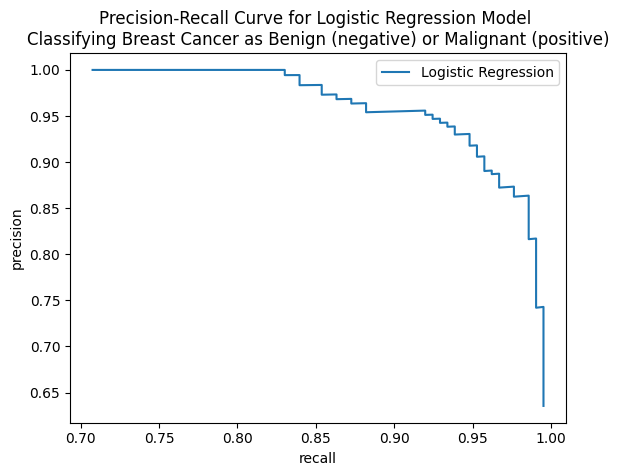

In [155]:
plt.plot(recalls, precisions, label='Logistic Regression')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall Curve for Logistic Regression Model \nClassifying Breast Cancer as Benign (negative) or Malignant (positive)')
plt.legend()

plt.show()

In [165]:
# use the trapezoidal rule to compute the area under the PR curve
total_area = 0

recalls_sorted_idx = np.argsort(recalls)

recalls_sorted = recalls[recalls_sorted_idx]
precisions_sorted = precisions[recalls_sorted_idx]

for i in range(len(recalls) - 1):
    height = (precisions_sorted[i] + precisions_sorted[i + 1]) / 2
    width = recalls_sorted[i + 1] - recalls_sorted[i]

    area = height * width 

    total_area += area

# add in any missing area from the left
min_recall_idx = np.argmin(recalls)

total_area += recalls[min_recall_idx] * precisions[min_recall_idx]

print(total_area)

0.9842264162492336
